## Script que faz clustering com HDBSCAN

O **HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)** é um algoritmo de agrupamento não supervisionado baseado na densidade dos dados, que estende o DBSCAN ao introduzir uma abordagem hierárquica e dinâmica para identificar clusters. Ele ajusta automaticamente os parâmetros de densidade e pode lidar com clusters de diferentes tamanhos e densidades, além de identificar pontos como ruídos.

Ideal para lidar com formas de clusters arbitrárias e dados com ruídos, o HDBSCAN é amplamente utilizado em **análise geoespacial**, **segmentação de imagens**, **classificação de texto baseada em embeddings** e **detecção de anomalias**. No caso de **classificação de texto**, o HDBSCAN pode agrupar documentos semelhantes a partir de vetores gerados por modelos de embeddings como Word2Vec, GloVe ou transformers, permitindo a descoberta de tópicos ou agrupamentos de textos sem rótulos prévios.

Principais Vantagens do HDBSCAN:
- **Sem necessidade de ε fixo**: O HDBSCAN ajusta dinamicamente os clusters com base na densidade local.
- **Robustez a ruídos**: Identifica eficientemente pontos que não pertencem a clusters densos.
- **Suporte a clusters de diferentes densidades**: Ideal para dados complexos.

Embora o HDBSCAN elimine a necessidade de configurar parâmetros como o raio de vizinhança (**ε**), ele ainda exige a definição de valores como o tamanho mínimo do cluster (**min_cluster_size**) e o número mínimo de amostras (**min_samples**), que podem impactar os resultados.


Também será havaliado:
- **Proporção de ruído**: Portarias que não foram possíveis classificar
- **Total de clustar válidos gerados**

Adicionalmente, o teste levará em consideração:
- A análise com o texto original e o texto tratado.
- A aplicação de métodos de redução de dimensionalidade para otimizar os dados.

---

**1)** Execução Inicial:
O script inicia com a leitura do arquivo:  
**`f'./saida/06_2_DOU2_portarias_mgi_tratado_NER_lematizado_embeddingsUSE_SBERT_Reducao_Kmeans_DBSCAN.parquet'`**  
Caso este arquivo não exista, executar o notebook **`06_2_Clustering_DBSCAN.ipynb`** para gerar os dados necessários.



## Bibliotecas

In [1]:
# Bibliotecas para manipulação de dados e cálculo
import pandas as pd
import numpy as np
import time  # Para medir o tempo de execução

# Bibliotecas para visualização
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Bibliotecas para clusterização
from hdbscan import HDBSCAN

# Bibliotecas de aprendizado de máquina e redução de dimensionalidade
from sklearn.decomposition import PCA, KernelPCA
# from sklearn.manifold import TSNE, LocallyLinearEmbedding
# from sklearn.preprocessing import StandardScaler
# import umap

# Métricas para avaliação de clusters
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Hierarquia para dendrogramas
from scipy.cluster.hierarchy import dendrogram, linkage



In [2]:
douItem = 2
secao = f'Secao0{douItem}'

# Lê o arquivo Parquet
df_portarias_mgi = pd.read_parquet(f'./saida/06_2_DOU{secao}_portarias_mgi_tratado_NER_lematizado_embeddingsUSE_SBERT_Reducao_Kmeans_DBSCAN.parquet', engine='pyarrow')  # ou engine='fastparquet'

# Exibe as primeiras linhas do DataFrame
df_portarias_mgi.shape


(19258, 99)

In [3]:
df_portarias_mgi.head()

id                             name idOficio pubName   artType  \
0  30266027          PORTARIA DE PESSOAL 529  9368436     DO2  Portaria   
1  30264410                 ATO PORTARIA 655  9368530     DO2  Portaria   
2  30265009      ATO PORTARIA DE PESSOAL 461  9368536     DO2  Portaria   
3  30265678  ATO PORTARIA DE PESSOAL SGP 606  9368541     DO2  Portaria   
4  30266030  ATO PORTARIA DE PESSOAL SGP 517  9368573     DO2  Portaria   

     pubDate                                           artClass  \
0 2023-01-25  00028:00006:00000:00000:00000:00000:00000:0000...   
1 2023-01-25  00028:00006:00000:00000:00000:00000:00000:0000...   
2 2023-01-25  00028:00006:00000:00000:00000:00000:00000:0000...   
3 2023-01-25  00028:00006:00000:00000:00000:00000:00000:0000...   
4 2023-01-25  00028:00006:00000:00000:00000:00000:00000:0000...   

                                         artCategory artSize artNotes  ...  \
0  Ministério da Gestão e da Inovação em Serviços...      12           ...   
1  Ministério da Gestão e da Inovação em Serviços...      12           ...   
2  Ministério da Gestão e da Inovação em Serviços...      12           ...   
3  Ministério da Gestão e da Inovação em Serviços...      12           ...   
4  Ministério da Gestão e da Inovação em Serviços...      12           ...   

  USE_Embeddings4_PCA_TSNE_dbscan USE_Embeddings4_UMAP_dbscan  \
0                              -1                           0   
1                              -1                           1   
2                              -1                           1   
3                             110                           2   
4                               0                          -1   

  SBERT_Embeddings1_dbscan SBERT_Embeddings1_TSNE_dbscan  \
0                        0                            -1   
1                        0                            -1   
2                        0                            -1   
3                        0                             0   
4                        0                            -1   

  SBERT_Embeddings1_PCA_TSNE_dbscan SBERT_Embeddings1_UMAP_dbscan  \
0                                -1                             0   
1                                -1                             1   
2                                -1                             1   
3                                 0                             2   
4                               968                             2   

  SBERT_Embeddings4_dbscan SBERT_Embeddings4_TSNE_dbscan  \
0                       -1                            -1   
1                       -1                             0   
2                       -1                             0   
3                       -1                             1   
4                       -1                            -1   

  SBERT_Embeddings4_PCA_TSNE_dbscan SBERT_Embeddings4_UMAP_dbscan  
0                                 0                             0  
1                                -1                             6  
2                                 1                             6  
3                                 2                             1  
4                                 3                             1  

[5 rows x 99 columns]

In [4]:
df_portarias_mgi.columns

Index(['id', 'name', 'idOficio', 'pubName', 'artType', 'pubDate', 'artClass',
       'artCategory', 'artSize', 'artNotes', 'numberPage', 'pdfPage',
       'editionNumber', 'highlightType', 'highlightPriority', 'highlight',
       'highlightimage', 'highlightimagename', 'idMateria', 'Identifica',
       'Data', 'Ementa', 'Titulo', 'SubTitulo', 'TextoHTML', 'file_name',
       'zip_name', 'Ano', 'Mes', 'Texto', 'Total_palavras', 'TextoTratado',
       'TextoTratado_TotalPalavras', 'Texto_sem_nomes', 'Nomes',
       'TextoTratadoSemNomes', 'TextoTratadoSemNomes_TotalPalavras',
       'TextoTratadoSemNomesLemmatized',
       'TextoTratadoSemNomesLemmatized_TotalPalavras', 'USE_Embeddings1',
       'USE_Embeddings4', 'SBERT_Embeddings1', 'SBERT_Embeddings4',
       'USE_Embeddings1_PCA', 'USE_Embeddings4_PCA', 'SBERT_Embeddings1_PCA',
       'SBERT_Embeddings4_PCA', 'USE_Embeddings1_TSNE', 'USE_Embeddings4_TSNE',
       'SBERT_Embeddings1_TSNE', 'SBERT_Embeddings4_TSNE',
       'USE_Embeddi

## Funções

In [5]:
def clusterizar_e_plotar_hdbscan(df, coluna, min_cluster_size, min_samples, sufixo_coluna="hdbscan", sufixo_grafico=""):
    """
    Aplica o HDBSCAN em dados reduzidos (ex.: t-SNE), calcula métricas de avaliação e gera o gráfico dos clusters.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados.
        coluna (str): Nome da coluna que contém os embeddings reduzidos (ex.: t-SNE).
        min_cluster_size (int): Valor do parâmetro min_cluster_size para o HDBSCAN.
        min_samples (int): Valor do parâmetro min_samples para o HDBSCAN.

    Retorno:
        pd.DataFrame: DataFrame atualizado com os clusters atribuídos pelo HDBSCAN.
    """
    # Extração dos embeddings
    embeddings_2d = np.vstack(df[coluna])

    # Aplicação do HDBSCAN
    hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean')
    clusters = hdbscan.fit_predict(embeddings_2d)

    # Adicionar clusters ao DataFrame
    cluster_column_name = f"{coluna}_{sufixo_coluna}"
    df[cluster_column_name] = clusters

    # Filtrar clusters válidos (excluindo ruído)
    mask_valid_clusters = clusters != -1  # Ignorar rótulos de ruído (-1)
    valid_embeddings = embeddings_2d[mask_valid_clusters]
    valid_clusters = clusters[mask_valid_clusters]

    # Verificar se há clusters válidos suficientes
    if len(set(valid_clusters)) > 1:  # Garantir que há mais de um cluster válido
        silhouette_avg = silhouette_score(valid_embeddings, valid_clusters)
        davies_bouldin = davies_bouldin_score(valid_embeddings, valid_clusters)
        calinski_harabasz = calinski_harabasz_score(valid_embeddings, valid_clusters)

        print("\n--- Métricas de Avaliação ---")
        print(f"Índice de Silhueta (clusters válidos): {silhouette_avg:.6f}")
        print(f"Índice de Davies-Bouldin (clusters válidos): {davies_bouldin:.6f}")
        print(f"Índice de Calinski-Harabasz (clusters válidos): {calinski_harabasz:.2f}")
    else:
        print("Não há clusters suficientes para calcular as métricas.")

    # Proporção de ruído
    num_points = len(clusters)
    num_noise = np.sum(clusters == -1)
    noise_ratio = num_noise / num_points
    print(f"Proporção de ruído: {noise_ratio:.2%}")

    # Total de clusters válidos (excluindo ruído)
    total_clusters_excl_noise = len(set(clusters) - {-1})  # Remove o cluster de ruído (-1)
    print(f"Total de clusters válidos (excluindo ruído): {total_clusters_excl_noise}")

    # Visualização dos clusters
    print("Gerando gráfico dos clusters...")
    plt.figure(figsize=(10, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', s=5)

    # Adicionar sufixo ao título do gráfico, se fornecido
    grafico_titulo = f"Clusterização com HDBSCAN (min_cluster_size={min_cluster_size}, min_samples={min_samples})"
    if sufixo_grafico:
        grafico_titulo += f" - {sufixo_grafico}"
    plt.title(grafico_titulo)
    
    plt.xlabel("Dimensão 1")
    plt.ylabel("Dimensão 2")
    plt.colorbar(label="Cluster")
    plt.grid(True)
    plt.show()


In [6]:
def processar_hdbscan_e_clusterizar(df, coluna_embeddings, min_cluster_sizes, min_samples_values):
    """
    Processa o HDBSCAN para várias combinações de parâmetros, identifica a melhor configuração,
    realiza a clusterização e gera a visualização.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados.
        coluna_embeddings (str): Nome da coluna do DataFrame com os embeddings a serem clusterizados.
        min_cluster_sizes (list): Lista de valores de min_cluster_size a serem testados.
        min_samples_values (list): Lista de valores de min_samples a serem testados.

    Retorno:
        pd.DataFrame: DataFrame atualizado com a clusterização da melhor configuração.
    """
    print("Iniciando o processamento para várias combinações de min_cluster_size e min_samples...")
    df_resultados = []
    
    embeddings = np.vstack(df[coluna_embeddings])
    for min_cluster_size in min_cluster_sizes:
        for min_samples in min_samples_values:
            print(f"Processando HDBSCAN para min_cluster_size={min_cluster_size}, min_samples={min_samples}...")
            hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean')
            clusters = hdbscan.fit_predict(embeddings)

            # Filtrar clusters válidos
            mask_valid_clusters = clusters != -1
            valid_embeddings = embeddings[mask_valid_clusters]
            valid_clusters = clusters[mask_valid_clusters]

            # Calcular métricas se houver mais de um cluster válido
            if len(set(valid_clusters)) > 1:
                silhouette = silhouette_score(valid_embeddings, valid_clusters)
                davies_bouldin = davies_bouldin_score(valid_embeddings, valid_clusters)
                calinski_harabasz = calinski_harabasz_score(valid_embeddings, valid_clusters)
            else:
                silhouette = davies_bouldin = calinski_harabasz = np.nan

            # Calcular proporção de ruído
            num_points = len(clusters)
            num_noise = np.sum(clusters == -1)
            noise_ratio = (num_noise / num_points) * 100  # Em percentual

            # Armazenar resultados
            df_resultados.append({
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'Silhouette Score': silhouette,
                'Davies-Bouldin Score': davies_bouldin,
                'Calinski-Harabasz Score': calinski_harabasz,
                'ruido_percent': round(noise_ratio, 2),
                'clusters_validos': len(set(valid_clusters)) - (1 if -1 in clusters else 0)
            })

    # Converter resultados para DataFrame
    df_resultados = pd.DataFrame(df_resultados)

    return df_resultados


## 1) Embedding Universal Sentence Encoder (USE)

###  1.1) Sem tratamento do texto

#### 1.1.1) Sem redução de dimensionalidade

In [16]:
vColuna = 'USE_Embeddings1'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [10], min_samples_values = [5,10])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=5, min_samples=5...
Processando HDBSCAN para min_cluster_size=5, min_samples=10...
Processando HDBSCAN para min_cluster_size=10, min_samples=5...
Processando HDBSCAN para min_cluster_size=10, min_samples=10...


min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 5            5          0.193352              1.413501   
1                 5           10          0.198769              1.409575   
2                10            5          0.205754              1.476547   
3                10           10          0.208135              1.420307   

   Calinski-Harabasz Score  ruido_percent  clusters_validos  
0               219.418137          22.19               135  
1               368.108948          19.39                67  
2               296.767151          21.22                96  
3               401.405945          18.86                61


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.208135
Índice de Davies-Bouldin (clusters válidos): 1.420307
Índice de Calinski-Harabasz (clusters válidos): 401.41
Proporção de ruído: 18.86%
Total de clusters válidos (excluindo ruído): 62
Gerando gráfico dos clusters...


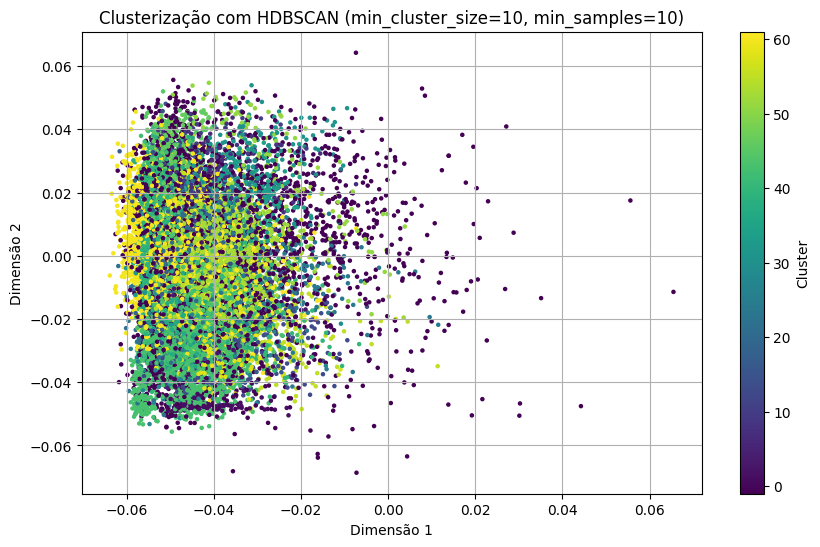

In [19]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=10, min_samples=10, sufixo_coluna="hdbscan")

#### 1.1.2) Redução com PCA

In [9]:
vColuna = 'USE_Embeddings1_PCA'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.142940              0.670697   
1                 20            5          0.208240              0.575902   
2                 20           10          0.209163              0.570636   
3                 20           15          0.204261              0.570617   
4                 30            2          0.224253              0.623357   
5                 30            5          0.293422              0.549233   
6                 30           10          0.427414              0.469401   
7                 30           15          0.424298              0.472150   
8                 40            2          0.224253              0.623357   
9                 40            5          0.429302              0.474767   
10                40           10          0.427414              0.469401   
11                40           15          0.424298              0.472150   
12                50            2          0.139612              0.565474   
13                50            5          0.428740              0.613175   
14                50           10          0.447172              0.548662   
15                50           15          0.442897              0.566043   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0                255.612259           1.06                 5  
1                259.982788           1.67                 4  
2                229.984009           1.86                 4  
3                238.207687           1.83                 4  
4                308.231873           0.80                 4  
5                318.522003           1.44                 3  
6                379.747437           1.57                 2  
7                400.174042           1.07                 2  
8                308.231873           0.80                 4  
9                423.509247           1.64                 2  
10               379.747437           1.57                 2  
11               400.174042           1.07                 2  
12               392.416138           3.78                 3  
13              1090.865356           1.26                 1  
14               947.532166           1.36                 1  
15              1056.945435           0.77                 1


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.424298
Índice de Davies-Bouldin (clusters válidos): 0.472150
Índice de Calinski-Harabasz (clusters válidos): 400.17
Proporção de ruído: 1.07%
Total de clusters válidos (excluindo ruído): 3
Gerando gráfico dos clusters...


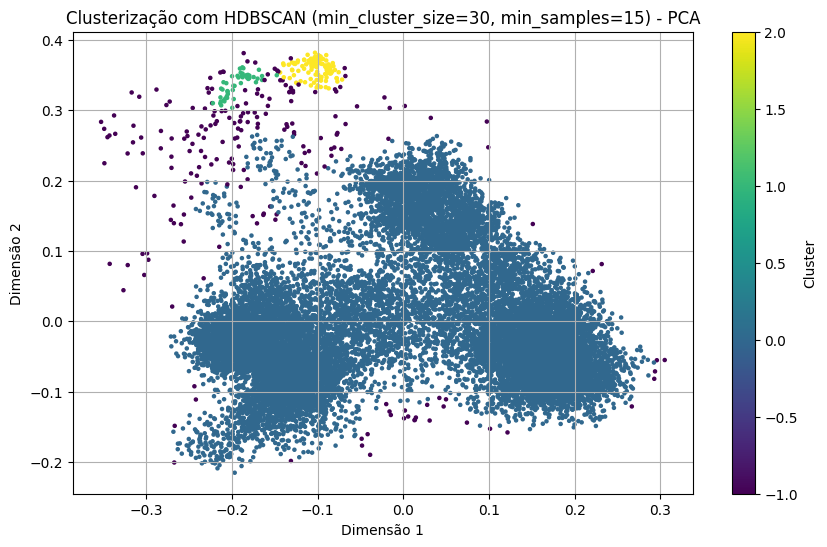

In [10]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=30, min_samples=15, sufixo_coluna="hdbscan", sufixo_grafico="PCA")

#### 1.1.3) Redução com t-SNE

In [11]:
vColuna = 'USE_Embeddings1_TSNE'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.474350              0.561792   
1                 20            5          0.494992              0.506636   
2                 20           10          0.497933              0.457806   
3                 20           15          0.501309              0.439445   
4                 30            2          0.465444              0.556000   
5                 30            5          0.484210              0.518051   
6                 30           10          0.478467              0.475947   
7                 30           15          0.492249              0.456410   
8                 40            2          0.495407              0.527338   
9                 40            5          0.490941              0.516030   
10                40           10          0.455471              0.504824   
11                40           15          0.459823              0.498082   
12                50            2          0.478900              0.547654   
13                50            5          0.468013              0.525856   
14                50           10          0.470731              0.515189   
15                50           15          0.467283              0.513913   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0               7416.287109           9.16               235  
1               8153.222168           9.25               203  
2               8802.915039           8.23               167  
3               9374.381836           9.04               153  
4               9553.823242           8.05               169  
5              10009.620117           7.39               150  
6              11161.846680           6.25               119  
7              11393.784180           7.35               114  
8              12434.458008           8.19               122  
9              12902.531250           7.50               107  
10             12065.017578           5.16                91  
11             12309.749023           5.13                89  
12             13987.119141           6.99                97  
13             12977.354492           5.07                87  
14             13009.629883           4.92                81  
15             13337.431641           5.62                84


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.501309
Índice de Davies-Bouldin (clusters válidos): 0.439445
Índice de Calinski-Harabasz (clusters válidos): 9374.38
Proporção de ruído: 9.04%
Total de clusters válidos (excluindo ruído): 154
Gerando gráfico dos clusters...


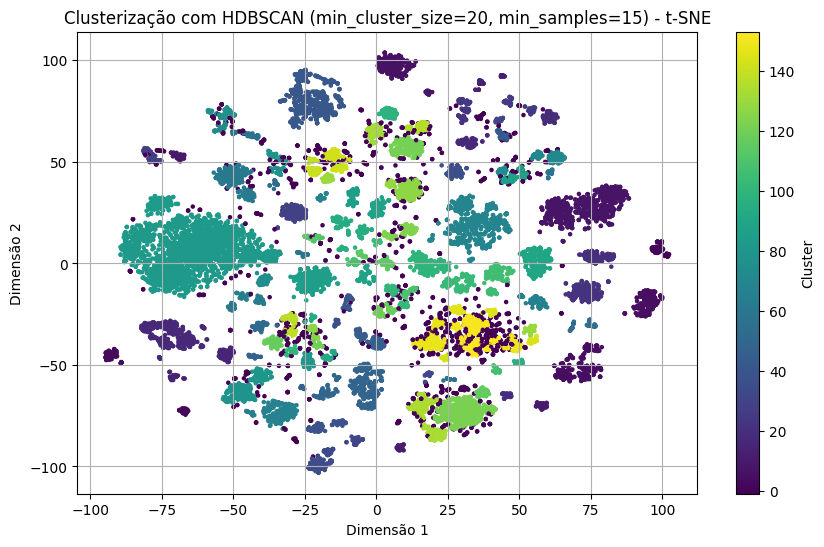

In [12]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=20, min_samples=15, sufixo_coluna="hdbscan", sufixo_grafico="t-SNE")

#### 1.1.4) Redução com PCA + t-SNE

In [22]:
vColuna = 'USE_Embeddings1_PCA_TSNE'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.510178              0.527958   
1                 20            5          0.510086              0.504460   
2                 20           10          0.501019              0.472031   
3                 20           15          0.537385              0.444728   
4                 30            2          0.515882              0.533899   
5                 30            5          0.505034              0.509681   
6                 30           10          0.488699              0.480692   
7                 30           15          0.522230              0.470197   
8                 40            2          0.502506              0.540322   
9                 40            5          0.496720              0.525149   
10                40           10          0.498422              0.503560   
11                40           15          0.488348              0.482488   
12                50            2          0.504080              0.530917   
13                50            5          0.503669              0.522355   
14                50           10          0.505612              0.518915   
15                50           15          0.486566              0.502715   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0               9917.986328           8.31               221  
1              10563.463867           8.48               198  
2               9832.749023           7.38               164  
3              12220.092773           9.59               156  
4              12857.784180           8.14               165  
5              12813.868164           5.99               142  
6              11248.448242           6.64               132  
7              13374.800781           8.50               125  
8              14783.440430           7.58               130  
9              15260.957031           6.36               113  
10             14190.739258           6.73               104  
11             13254.203125           6.02                97  
12             15977.794922           6.94                97  
13             17069.000000           6.63                91  
14             17759.394531           6.54                87  
15             14781.989258           6.14                85


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.537385
Índice de Davies-Bouldin (clusters válidos): 0.444728
Índice de Calinski-Harabasz (clusters válidos): 12220.09
Proporção de ruído: 9.59%
Total de clusters válidos (excluindo ruído): 157
Gerando gráfico dos clusters...


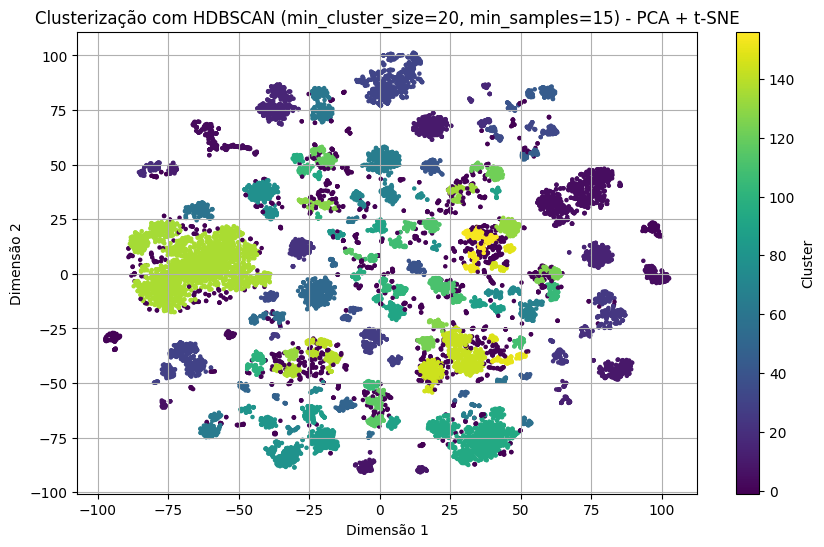

In [23]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=20, min_samples=15, sufixo_coluna="hdbscan", sufixo_grafico="PCA + t-SNE")

#### 1.1.5) Redução com UMAP

In [20]:
vColuna = 'USE_Embeddings1_UMAP'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.691086              0.384067   
1                 20            5          0.673542              0.323995   
2                 20           10          0.684412              0.305522   
3                 20           15          0.735581              0.283154   
4                 30            2          0.706676              0.368812   
5                 30            5          0.670640              0.329798   
6                 30           10          0.690294              0.322315   
7                 30           15          0.713025              0.310522   
8                 40            2          0.697407              0.387753   
9                 40            5          0.674285              0.345042   
10                40           10          0.662501              0.333981   
11                40           15          0.708916              0.318503   
12                50            2          0.697984              0.393703   
13                50            5          0.667186              0.368065   
14                50           10          0.664943              0.349791   
15                50           15          0.703017              0.328121   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0             388658.718750          10.81               251  
1             113864.257812           9.28               226  
2             123298.828125           9.18               212  
3             295314.093750          11.48               213  
4             315342.656250          10.84               197  
5             132543.937500           9.52               179  
6             133752.750000           9.78               177  
7             234260.984375          11.10               167  
8             225062.984375          10.61               166  
9             124166.375000           9.40               150  
10            130134.992188           8.45               141  
11            224055.640625          10.55               141  
12            180061.046875          11.27               131  
13            108914.265625           8.26               120  
14            121869.210938           9.20               117  
15            173665.828125          10.39               116


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.703017
Índice de Davies-Bouldin (clusters válidos): 0.328121
Índice de Calinski-Harabasz (clusters válidos): 173665.83
Proporção de ruído: 10.39%
Total de clusters válidos (excluindo ruído): 117
Gerando gráfico dos clusters...


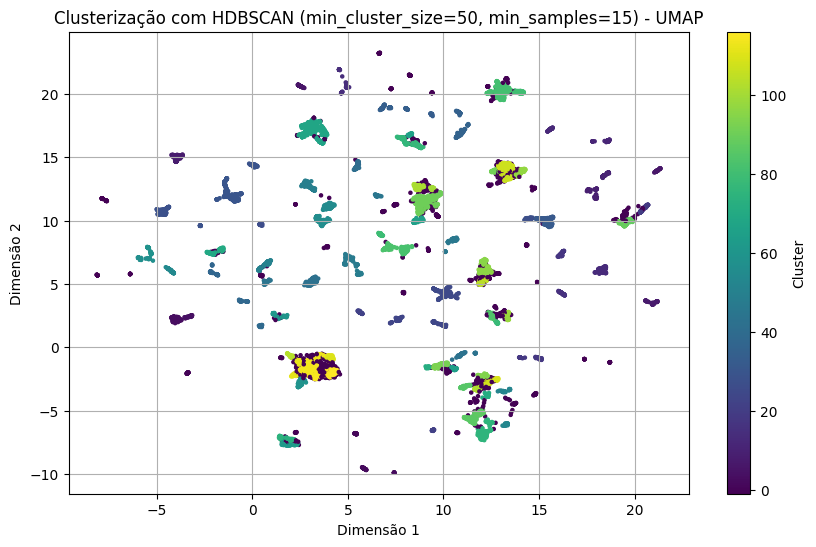

In [21]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=50, min_samples=15, sufixo_coluna="hdbscan", sufixo_grafico="UMAP")

###  1.2) Com tratamento do texto

#### 1.2.1) Sem redução de dimensionalidade

In [24]:
vColuna = 'USE_Embeddings4'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [10], min_samples_values = [5, 10])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=5, min_samples=5...
Processando HDBSCAN para min_cluster_size=5, min_samples=10...
Processando HDBSCAN para min_cluster_size=10, min_samples=5...
Processando HDBSCAN para min_cluster_size=10, min_samples=10...


min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 5            5          0.240370              1.326286   
1                 5           10          0.209129              1.270184   
2                10            5          0.207337              1.352727   
3                10           10          0.215172              1.286701   

   Calinski-Harabasz Score  ruido_percent  clusters_validos  
0               206.860916          28.70               173  
1               263.874054          22.08                95  
2               262.698486          19.30               110  
3               312.442261          22.60                81


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.207337
Índice de Davies-Bouldin (clusters válidos): 1.352727
Índice de Calinski-Harabasz (clusters válidos): 262.70
Proporção de ruído: 19.30%
Total de clusters válidos (excluindo ruído): 111
Gerando gráfico dos clusters...


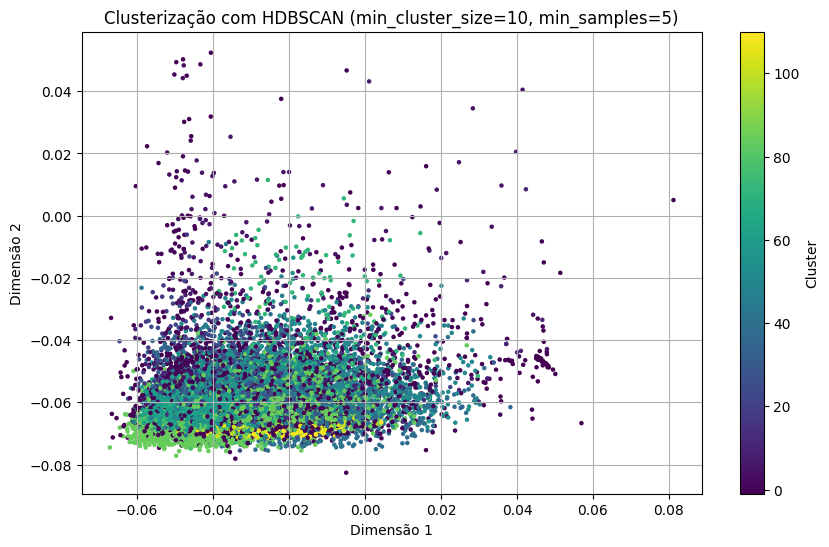

In [25]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=10, min_samples=5, sufixo_coluna="hdbscan")

#### 1.2.2) Redução com PCA

In [26]:
vColuna = 'USE_Embeddings4_PCA'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2         -0.252113              1.290654   
1                 20            5          0.229730              0.621639   
2                 20           10          0.313878              0.542369   
3                 20           15          0.310273              0.544865   
4                 30            2          0.226861              0.626550   
5                 30            5          0.229730              0.621639   
6                 30           10          0.396132              0.642635   
7                 30           15          0.422846              0.539041   
8                 40            2          0.226861              0.626550   
9                 40            5          0.381036              0.610139   
10                40           10          0.319111              0.599511   
11                40           15          0.315642              0.579639   
12                50            2          0.367016              0.591482   
13                50            5          0.381036              0.610139   
14                50           10          0.319111              0.599511   
15                50           15          0.348618              0.563323   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0               1826.940308           5.73                12  
1                700.491516           1.45                 2  
2               5642.263184           7.09                 5  
3               5723.943359           6.22                 5  
4                392.417725           1.66                 3  
5                700.491516           1.45                 2  
6               7335.754883           2.97                 3  
7               7134.031738           6.34                 4  
8                392.417725           1.66                 3  
9               1285.540771           0.90                 1  
10              4420.993164           9.95                 6  
11              4429.497559           9.60                 6  
12               521.945251           1.16                 2  
13              1285.540771           0.90                 1  
14              4420.993164           9.95                 6  
15              6638.470215           9.52                 4


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.422846
Índice de Davies-Bouldin (clusters válidos): 0.539041
Índice de Calinski-Harabasz (clusters válidos): 7134.03
Proporção de ruído: 6.34%
Total de clusters válidos (excluindo ruído): 5
Gerando gráfico dos clusters...


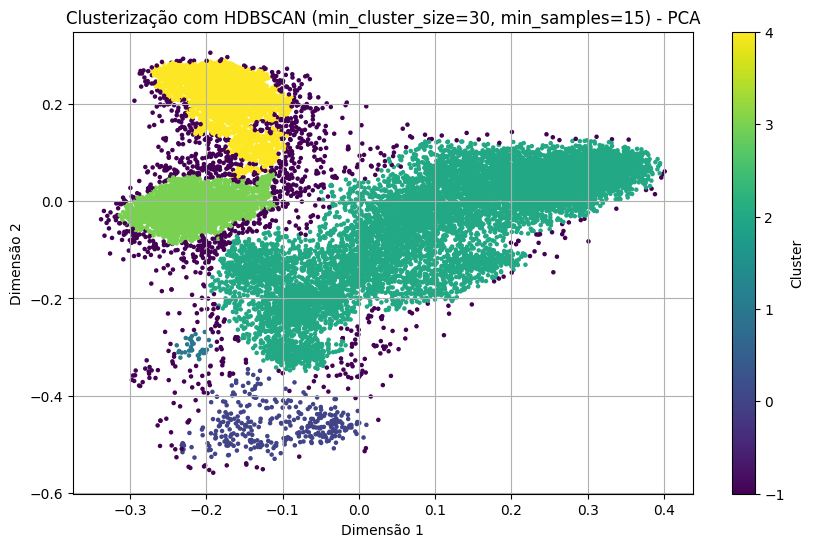

In [27]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=30, min_samples=15, sufixo_coluna="hdbscan", sufixo_grafico="PCA")

#### 1.2.3) Redução com t-SNE

In [28]:
vColuna = 'USE_Embeddings4_TSNE'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.531608              0.585054   
1                 20            5          0.527370              0.535515   
2                 20           10          0.522671              0.501107   
3                 20           15          0.532367              0.478550   
4                 30            2          0.538628              0.574835   
5                 30            5          0.541927              0.539164   
6                 30           10          0.545084              0.515544   
7                 30           15          0.535229              0.499142   
8                 40            2          0.540590              0.564476   
9                 40            5          0.532466              0.557703   
10                40           10          0.529712              0.531454   
11                40           15          0.474226              0.518034   
12                50            2          0.545930              0.558271   
13                50            5          0.517816              0.554165   
14                50           10          0.462901              0.554116   
15                50           15          0.454860              0.545566   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0              35974.250000          11.79               280  
1              24922.753906          10.81               235  
2              21498.601562          11.34               196  
3              21295.253906          11.29               173  
4              35387.546875           9.56               190  
5              30092.171875           9.72               175  
6              24852.478516          10.45               150  
7              23280.773438          10.43               138  
8              34402.605469           9.78               154  
9              29190.716797           8.83               142  
10             25339.275391          10.00               127  
11             11168.641602           6.97               111  
12             33404.859375           9.83               131  
13             26593.210938           7.68               122  
14             14470.064453           6.54               105  
15             11827.295898           6.08                98


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.541927
Índice de Davies-Bouldin (clusters válidos): 0.539164
Índice de Calinski-Harabasz (clusters válidos): 30092.17
Proporção de ruído: 9.72%
Total de clusters válidos (excluindo ruído): 176
Gerando gráfico dos clusters...


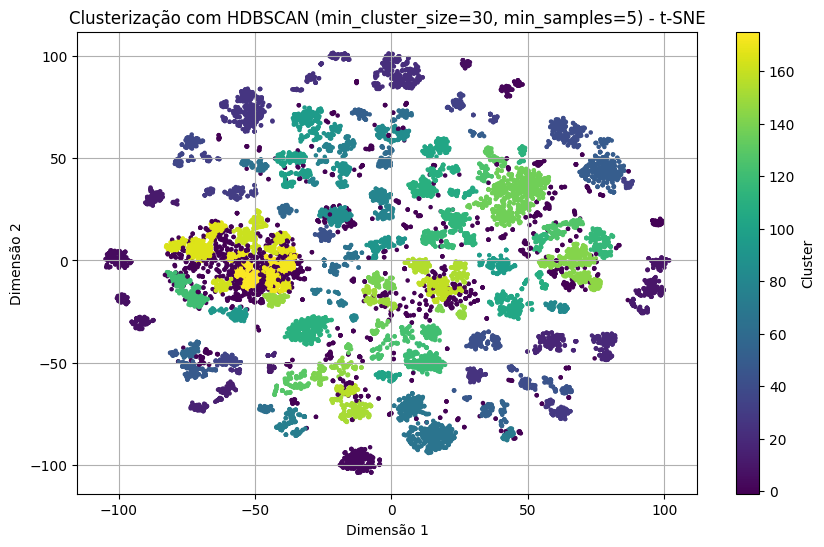

In [30]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=30, min_samples=5, sufixo_coluna="hdbscan", sufixo_grafico="t-SNE")

#### 1.2.4) Redução com PCA + t-SNE

In [31]:
vColuna = 'USE_Embeddings4_PCA_TSNE'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.469737              0.578318   
1                 20            5          0.531662              0.543799   
2                 20           10          0.540087              0.495799   
3                 20           15          0.544791              0.470092   
4                 30            2          0.485574              0.578569   
5                 30            5          0.477938              0.562390   
6                 30           10          0.495599              0.516308   
7                 30           15          0.535778              0.509848   
8                 40            2          0.492312              0.547809   
9                 40            5          0.482726              0.549216   
10                40           10          0.484417              0.539504   
11                40           15          0.527373              0.516007   
12                50            2          0.495483              0.555415   
13                50            5          0.496095              0.543242   
14                50           10          0.492034              0.527904   
15                50           15          0.533879              0.527832   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0               9561.990234           6.74               224  
1              29952.382812           8.50               212  
2              25036.271484           8.37               178  
3              22041.357422           8.42               154  
4              11809.823242           6.55               173  
5              12731.980469           5.87               156  
6              13055.278320           7.00               140  
7              25008.500000           7.45               133  
8              13974.648438           6.23               136  
9              14595.792969           5.20               129  
10             14115.971680           6.44               126  
11             24517.185547           6.70               121  
12             15185.337891           6.31               119  
13             16437.509766           6.29               109  
14             15673.870117           6.82               105  
15             26043.347656           7.69               108


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.544791
Índice de Davies-Bouldin (clusters válidos): 0.470092
Índice de Calinski-Harabasz (clusters válidos): 22041.36
Proporção de ruído: 8.42%
Total de clusters válidos (excluindo ruído): 155
Gerando gráfico dos clusters...


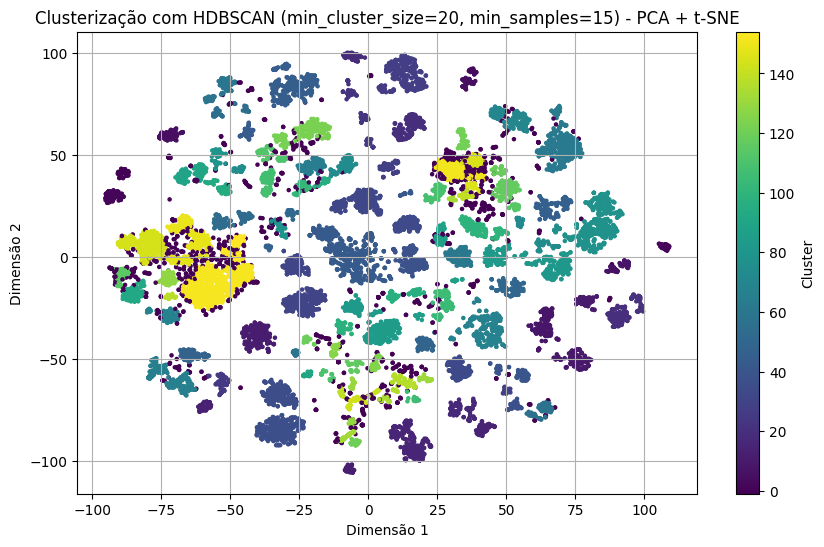

In [32]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=20, min_samples=15, sufixo_coluna="hdbscan", sufixo_grafico="PCA + t-SNE")

#### 1.2.5) Redução com UMAP

In [33]:
vColuna = 'USE_Embeddings4_UMAP'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.682181              0.402582   
1                 20            5          0.692675              0.352026   
2                 20           10          0.740822              0.314974   
3                 20           15          0.754387              0.294544   
4                 30            2          0.689916              0.397142   
5                 30            5          0.705897              0.364841   
6                 30           10          0.729175              0.337365   
7                 30           15          0.730236              0.330733   
8                 40            2          0.698902              0.394075   
9                 40            5          0.707186              0.371463   
10                40           10          0.714784              0.354322   
11                40           15          0.720481              0.348204   
12                50            2          0.687714              0.408242   
13                50            5          0.692366              0.390379   
14                50           10          0.685881              0.387859   
15                50           15          0.712282              0.363900   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0             317169.562500          11.40               262  
1             233847.687500          11.27               235  
2             311367.812500          13.70               224  
3             319101.187500          15.03               223  
4             275895.250000          12.61               199  
5             219673.703125          11.14               186  
6             208977.156250          13.14               184  
7             192156.640625          13.59               175  
8             177475.718750          13.27               165  
9             151608.109375          12.17               160  
10            139752.484375          12.44               151  
11            138046.421875          11.72               141  
12            171928.531250          13.33               132  
13            146744.796875          13.54               133  
14             65686.500000          11.09               118  
15            130784.578125          12.05               122


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.712282
Índice de Davies-Bouldin (clusters válidos): 0.363900
Índice de Calinski-Harabasz (clusters válidos): 130784.58
Proporção de ruído: 12.05%
Total de clusters válidos (excluindo ruído): 123
Gerando gráfico dos clusters...


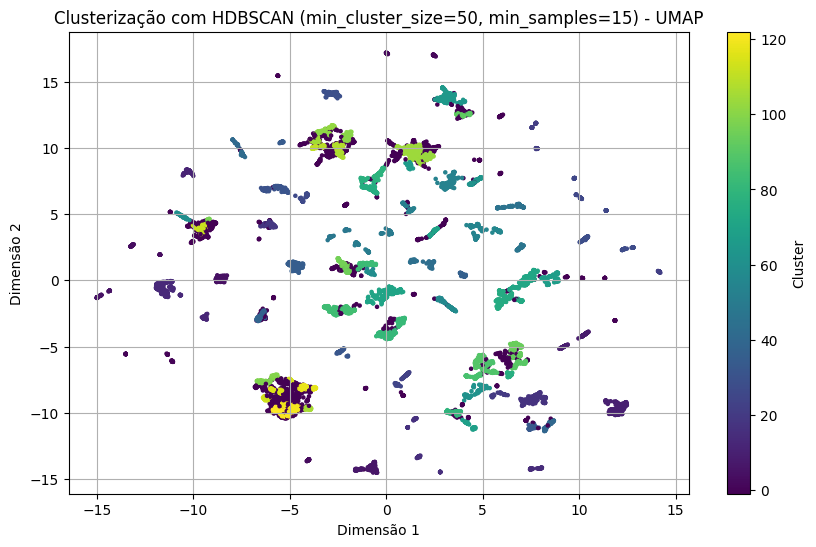

In [34]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=50, min_samples=15, sufixo_coluna="hdbscan", sufixo_grafico="UMAP")

## 2) Embedding Sentence-BERT (SBERT)

###  2.1) Sem tratamento do texto

#### 2.1.1) Sem redução de dimensionalidade

In [35]:
vColuna = 'SBERT_Embeddings1'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [5,10], min_samples_values = [5])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=5, min_samples=5...
Processando HDBSCAN para min_cluster_size=5, min_samples=10...
Processando HDBSCAN para min_cluster_size=10, min_samples=5...
Processando HDBSCAN para min_cluster_size=10, min_samples=10...


min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 5            5          0.271262              1.121093   
1                 5           10          0.328480              1.031639   
2                10            5          0.290792              1.172554   
3                10           10          0.336669              1.041883   

   Calinski-Harabasz Score  ruido_percent  clusters_validos  
0               162.271774          49.73               286  
1               262.633331          59.06               153  
2               238.061630          51.08               173  
3               306.334381          59.14               129


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.290792
Índice de Davies-Bouldin (clusters válidos): 1.172554
Índice de Calinski-Harabasz (clusters válidos): 238.06
Proporção de ruído: 51.08%
Total de clusters válidos (excluindo ruído): 174
Gerando gráfico dos clusters...


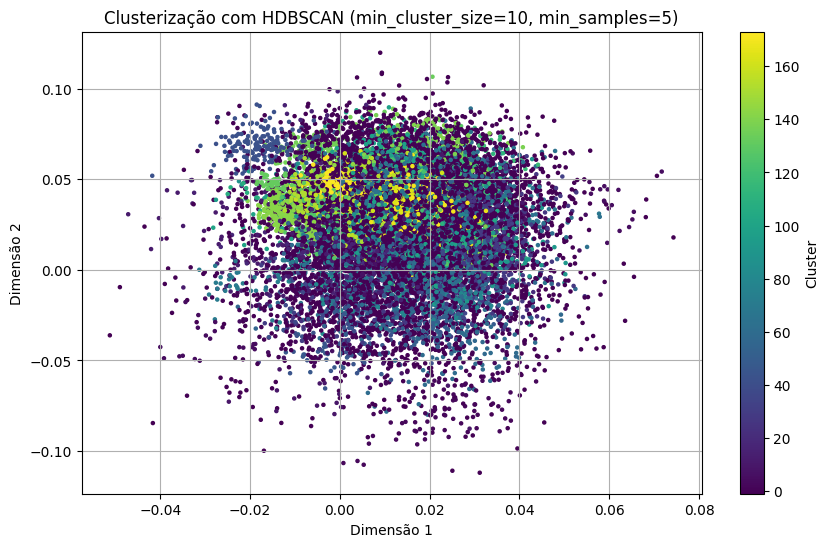

In [36]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=10, min_samples=5, sufixo_coluna="hdbscan")

#### 2.1.2) Redução com PCA

In [37]:
vColuna = 'SBERT_Embeddings1_PCA'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.306373              0.858379   
1                 20            5         -0.019916              0.678212   
2                 20           10          0.283721              0.628932   
3                 20           15          0.254244              0.631954   
4                 30            2          0.277251              0.858104   
5                 30            5          0.092040              0.781447   
6                 30           10          0.283721              0.628932   
7                 30           15          0.277577              0.598249   
8                 40            2          0.151468              0.587550   
9                 40            5          0.245274              0.779227   
10                40           10          0.283721              0.628932   
11                40           15          0.277577              0.598249   
12                50            2          0.389390              0.517576   
13                50            5         -0.053777              0.782306   
14                50           10          0.284571              0.642921   
15                50           15          0.277678              0.636135   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0              10063.957031          35.48               284  
1                101.115425           5.21                 7  
2                247.106110           5.16                 2  
3                127.418808           5.84                 3  
4               8873.922852          40.35               176  
5                109.438385           5.13                 4  
6                247.106110           5.16                 2  
7                202.701294           5.79                 2  
8                189.219925           1.56                 2  
9                111.742691           5.48                 2  
10               247.106110           5.16                 2  
11               202.701294           5.79                 2  
12               253.087860           1.80                 1  
13               579.872986          31.76                21  
14               286.033173           5.38                 1  
15               203.860031           6.00                 1


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.389390
Índice de Davies-Bouldin (clusters válidos): 0.517576
Índice de Calinski-Harabasz (clusters válidos): 253.09
Proporção de ruído: 1.80%
Total de clusters válidos (excluindo ruído): 2
Gerando gráfico dos clusters...


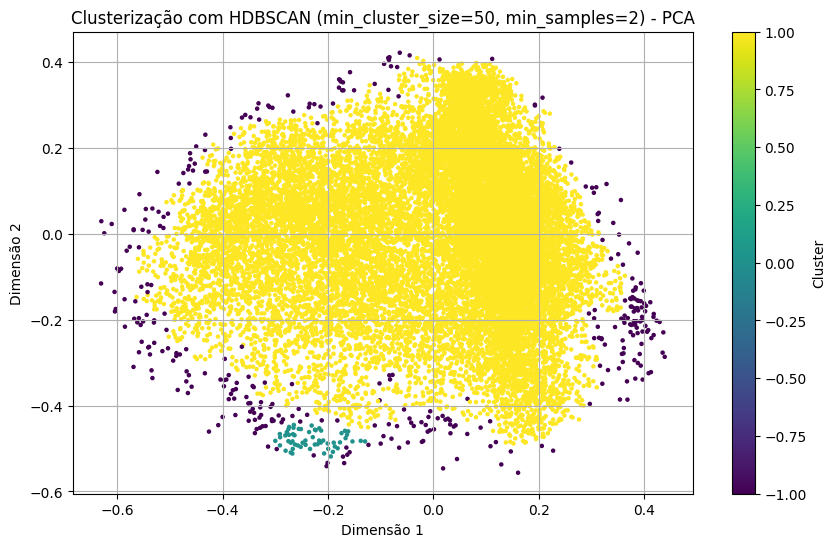

In [38]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=50, min_samples=2, sufixo_coluna="hdbscan", sufixo_grafico="PCA")

#### 2.1.3) Redução com t-SNE

In [39]:
vColuna = 'SBERT_Embeddings1_TSNE'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.511520              0.577089   
1                 20            5          0.519440              0.544985   
2                 20           10          0.527199              0.510967   
3                 20           15          0.545108              0.477111   
4                 30            2          0.504012              0.585944   
5                 30            5          0.511935              0.571295   
6                 30           10          0.540218              0.519397   
7                 30           15          0.532428              0.507327   
8                 40            2          0.525105              0.568503   
9                 40            5          0.521713              0.578915   
10                40           10          0.525153              0.546181   
11                40           15          0.535131              0.531626   
12                50            2          0.523668              0.560304   
13                50            5          0.511740              0.571030   
14                50           10          0.522329              0.551991   
15                50           15          0.538243              0.527604   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0              29744.339844          12.64               272  
1              26245.435547          13.75               246  
2              26666.541016          15.51               214  
3              26472.076172          16.35               192  
4              27621.710938          11.27               183  
5              26715.308594          11.64               169  
6              29711.607422          13.94               156  
7              25239.515625          13.86               147  
8              29739.498047          12.52               142  
9              28868.494141          11.94               133  
10             26027.273438          12.12               120  
11             26046.269531          13.79               116  
12             28413.818359          11.38               118  
13             25257.292969          10.79               114  
14             25194.494141          12.51               106  
15             26496.437500          15.09               107


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.538243
Índice de Davies-Bouldin (clusters válidos): 0.527604
Índice de Calinski-Harabasz (clusters válidos): 26496.44
Proporção de ruído: 15.09%
Total de clusters válidos (excluindo ruído): 108
Gerando gráfico dos clusters...


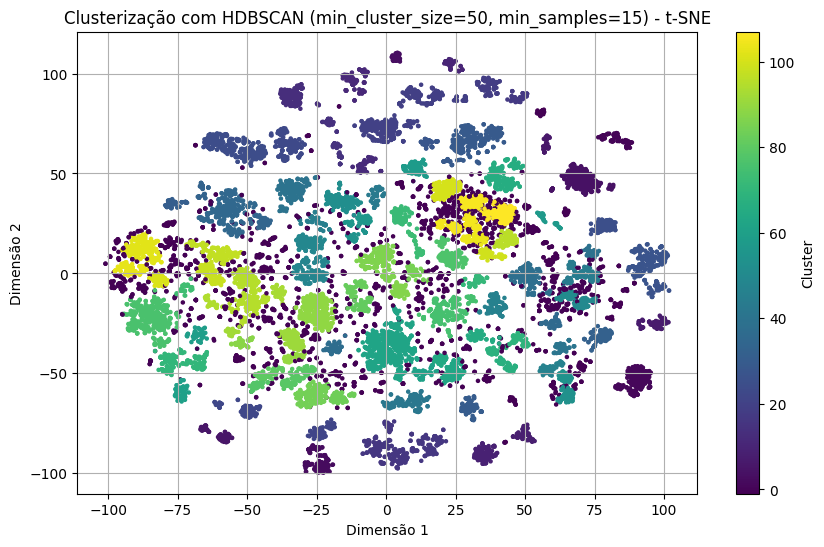

In [42]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=50, min_samples=15, sufixo_coluna="hdbscan", sufixo_grafico="t-SNE")

#### 2.1.4) Redução com PCA + t-SNE

In [43]:
vColuna = 'SBERT_Embeddings1_PCA_TSNE'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.513668              0.570197   
1                 20            5          0.511864              0.539467   
2                 20           10          0.486322              0.509158   
3                 20           15          0.538608              0.465300   
4                 30            2          0.477951              0.584757   
5                 30            5          0.509208              0.548821   
6                 30           10          0.508194              0.523866   
7                 30           15          0.518012              0.523697   
8                 40            2          0.484654              0.595202   
9                 40            5          0.498388              0.563925   
10                40           10          0.462628              0.557040   
11                40           15          0.522718              0.545565   
12                50            2          0.494802              0.587420   
13                50            5          0.492437              0.575039   
14                50           10          0.504022              0.569178   
15                50           15          0.529567              0.559083   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0              27562.140625          13.58               268  
1              24265.085938          12.33               240  
2              18712.625000          12.00               194  
3              25071.396484          17.38               185  
4              19322.224609           9.69               170  
5              23241.490234          11.73               166  
6              21530.126953          12.78               146  
7              22560.005859          13.91               135  
8              20985.802734           9.81               141  
9              23311.191406          11.19               131  
10             15612.446289          10.07               115  
11             25603.169922          14.24               115  
12             22403.166016          10.41               118  
13             22897.710938          10.50               109  
14             24929.431641          12.07                98  
15             27638.265625          14.59                98


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.477951
Índice de Davies-Bouldin (clusters válidos): 0.584757
Índice de Calinski-Harabasz (clusters válidos): 19322.22
Proporção de ruído: 9.69%
Total de clusters válidos (excluindo ruído): 171
Gerando gráfico dos clusters...


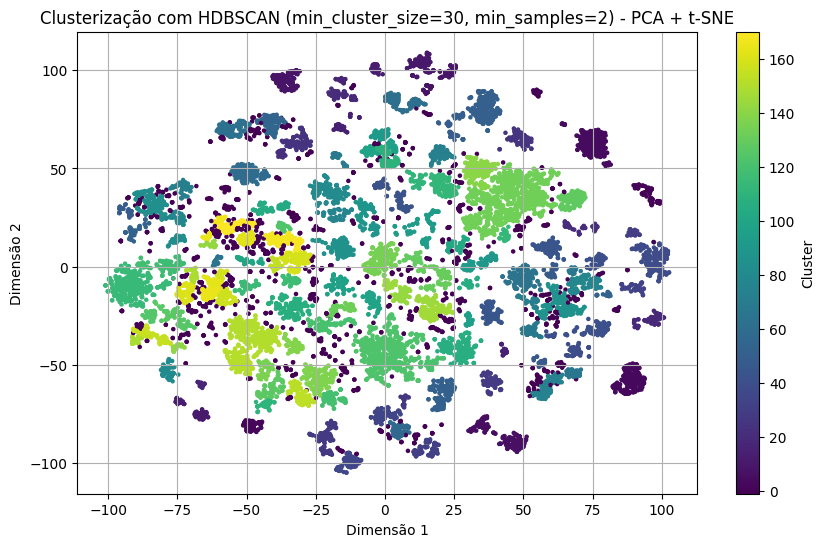

In [44]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=30, min_samples=2, sufixo_coluna="hdbscan", sufixo_grafico="PCA + t-SNE")

#### 2.1.5) Redução com UMAP

In [45]:
vColuna = 'SBERT_Embeddings1_UMAP'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.664650              0.430668   
1                 20            5          0.672761              0.369848   
2                 20           10          0.684531              0.325444   
3                 20           15          0.703573              0.308319   
4                 30            2          0.654959              0.436539   
5                 30            5          0.688035              0.359676   
6                 30           10          0.652712              0.355010   
7                 30           15          0.660591              0.344344   
8                 40            2          0.659422              0.431847   
9                 40            5          0.660138              0.363530   
10                40           10          0.663958              0.361842   
11                40           15          0.667663              0.353323   
12                50            2          0.640141              0.450962   
13                50            5          0.651805              0.386951   
14                50           10          0.668204              0.384323   
15                50           15          0.673318              0.378272   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0             121665.429688          12.56               295  
1              96178.421875          11.09               239  
2              96224.976562          10.63               216  
3             103840.226562          11.98               208  
4              99133.101562          10.55               195  
5              93758.468750          11.23               174  
6              68896.039062           9.99               162  
7              70450.257812          10.08               158  
8              93423.039062          12.47               148  
9              77077.492188          11.53               134  
10             76353.539062          11.27               129  
11             78560.351562          11.31               130  
12             67854.453125          11.20               119  
13             70335.507812          10.02               113  
14             74303.265625          11.71               114  
15             76149.156250          11.42               113


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.652712
Índice de Davies-Bouldin (clusters válidos): 0.355010
Índice de Calinski-Harabasz (clusters válidos): 68896.04
Proporção de ruído: 9.99%
Total de clusters válidos (excluindo ruído): 163
Gerando gráfico dos clusters...


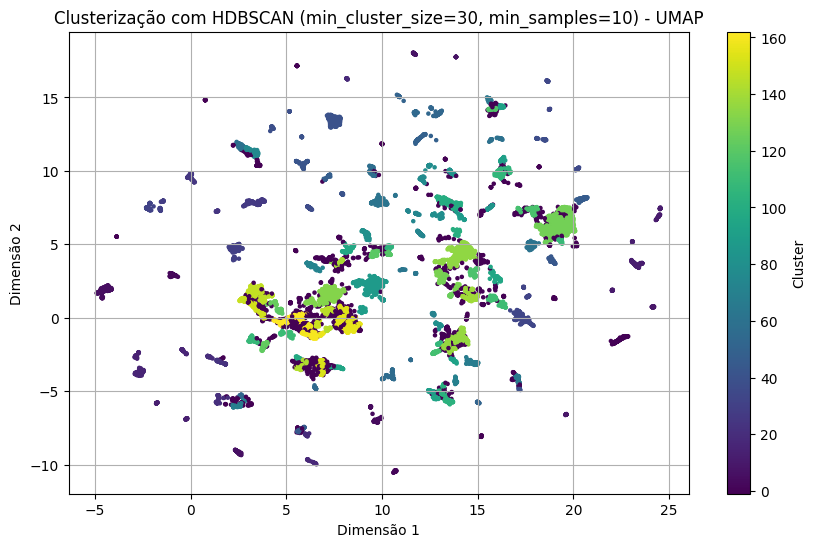

In [46]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=30, min_samples=10, sufixo_coluna="hdbscan", sufixo_grafico="UMAP")

###  2.2) Com tratamento do texto

#### 2.2.1) Sem redução de dimensionalidade

In [47]:
vColuna = 'SBERT_Embeddings4'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [5,10], min_samples_values = [5, 10])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=5, min_samples=5...
Processando HDBSCAN para min_cluster_size=5, min_samples=10...
Processando HDBSCAN para min_cluster_size=10, min_samples=5...
Processando HDBSCAN para min_cluster_size=10, min_samples=10...


min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 5            5          0.263368              1.135183   
1                 5           10          0.259956              1.084759   
2                10            5          0.234843              1.249744   
3                10           10          0.265306              1.122500   

   Calinski-Harabasz Score  ruido_percent  clusters_validos  
0               136.039047          48.66               293  
1               224.476181          51.26               144  
2               224.424881          43.60               166  
3               272.303955          50.86               117


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.234843
Índice de Davies-Bouldin (clusters válidos): 1.249744
Índice de Calinski-Harabasz (clusters válidos): 224.42
Proporção de ruído: 43.60%
Total de clusters válidos (excluindo ruído): 167
Gerando gráfico dos clusters...


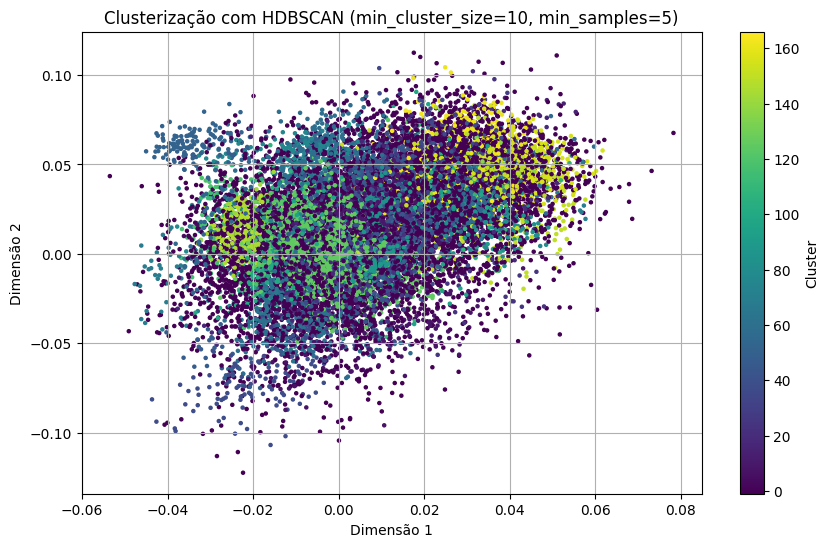

In [49]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=10, min_samples=5, sufixo_coluna="hdbscan")

#### 2.2.2) Redução com PCA

In [53]:
vColuna = 'SBERT_Embeddings4_PCA'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [2, 5], min_samples_values = [2, 5])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=2, min_samples=2...
Processando HDBSCAN para min_cluster_size=2, min_samples=5...
Processando HDBSCAN para min_cluster_size=5, min_samples=2...
Processando HDBSCAN para min_cluster_size=5, min_samples=5...


min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 2            2          0.437509              0.595265   
1                 2            5          0.446016              0.581887   
2                 5            2          0.386721              0.706568   
3                 5            5          0.444932              0.593686   

   Calinski-Harabasz Score  ruido_percent  clusters_validos  
0             18236.558594          23.21              2942  
1             12198.464844          49.06              1301  
2             15329.271484          24.98              1411  
3              6343.301758          47.38               745


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.437509
Índice de Davies-Bouldin (clusters válidos): 0.595265
Índice de Calinski-Harabasz (clusters válidos): 18236.56
Proporção de ruído: 23.21%
Total de clusters válidos (excluindo ruído): 2943
Gerando gráfico dos clusters...


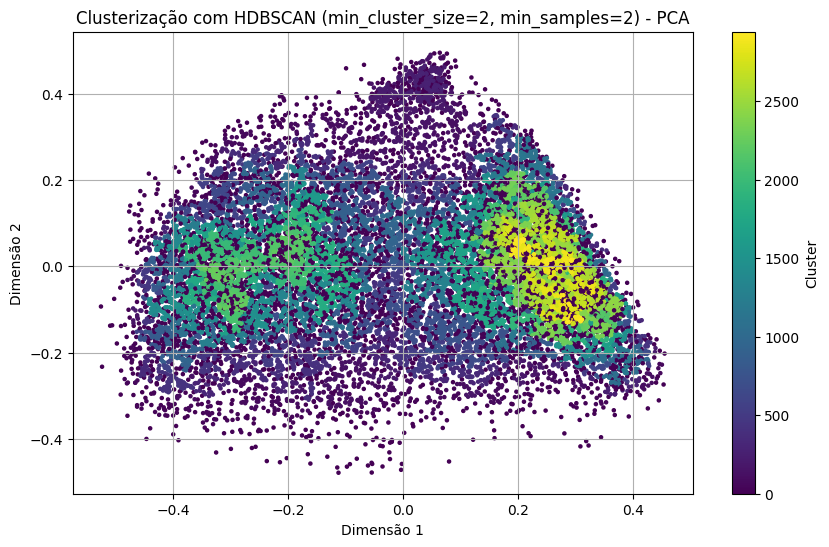

In [54]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=2, min_samples=2, sufixo_coluna="hdbscan", sufixo_grafico="PCA")

#### 2.2.3) Redução com t-SNE

In [55]:
vColuna = 'SBERT_Embeddings4_TSNE'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.521668              0.592532   
1                 20            5          0.535635              0.559608   
2                 20           10          0.551823              0.524696   
3                 20           15          0.559257              0.487177   
4                 30            2          0.519777              0.596260   
5                 30            5          0.532925              0.582095   
6                 30           10          0.477143              0.538990   
7                 30           15          0.561689              0.516529   
8                 40            2          0.510149              0.597835   
9                 40            5          0.525117              0.603608   
10                40           10          0.480366              0.577673   
11                40           15          0.497432              0.558990   
12                50            2          0.515437              0.599218   
13                50            5          0.511691              0.598248   
14                50           10          0.505294              0.569671   
15                50           15          0.481048              0.555671   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0              35576.292969          12.76               301  
1              28270.386719          12.75               263  
2              26561.904297          14.18               216  
3              25867.791016          16.20               199  
4              28184.673828          10.07               196  
5              28854.150391          11.05               190  
6              11604.885742          11.06               149  
7              29509.492188          15.73               154  
8              27703.708984          10.68               155  
9              28057.703125          11.54               156  
10             16703.689453          11.39               122  
11             16434.335938          12.99               120  
12             29770.675781          12.33               128  
13             28413.443359          11.04               120  
14             18407.212891          12.40               104  
15             14047.011719          12.74                99


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.532925
Índice de Davies-Bouldin (clusters válidos): 0.582095
Índice de Calinski-Harabasz (clusters válidos): 28854.15
Proporção de ruído: 11.05%
Total de clusters válidos (excluindo ruído): 191
Gerando gráfico dos clusters...


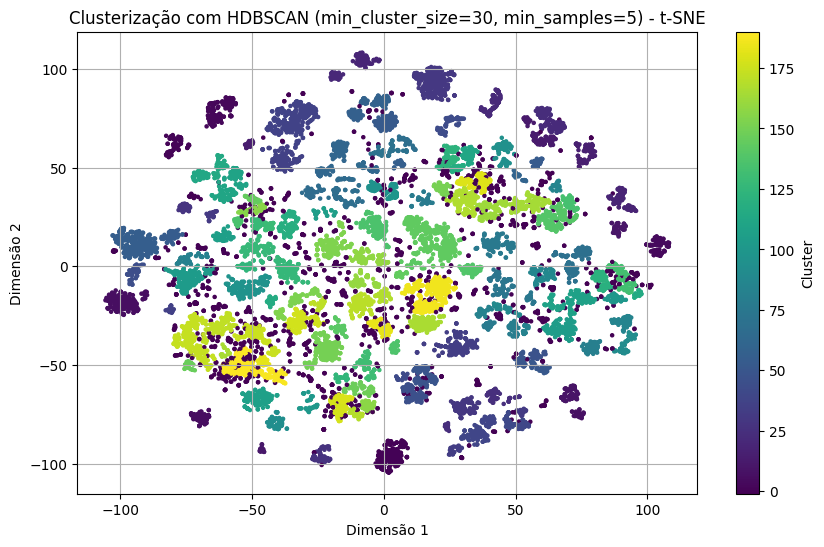

In [56]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=30, min_samples=5, sufixo_coluna="hdbscan", sufixo_grafico="t-SNE")

#### 2.2.4) Redução com PCA + t-SNE

In [57]:
vColuna = 'SBERT_Embeddings4_PCA_TSNE'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.533560              0.602027   
1                 20            5          0.498469              0.547102   
2                 20           10          0.518738              0.495980   
3                 20           15          0.522267              0.476448   
4                 30            2          0.474038              0.599615   
5                 30            5          0.497715              0.565996   
6                 30           10          0.518269              0.533492   
7                 30           15          0.519234              0.524159   
8                 40            2          0.479428              0.606852   
9                 40            5          0.489215              0.591534   
10                40           10          0.510116              0.550478   
11                40           15          0.504914              0.561220   
12                50            2          0.482682              0.627613   
13                50            5          0.494610              0.598743   
14                50           10          0.508894              0.565132   
15                50           15          0.503148              0.574502   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0              33461.503906          12.39               307  
1              16187.132812          11.06               251  
2              17678.224609          12.67               210  
3              17491.906250          13.82               195  
4              18631.250000           8.68               186  
5              20027.542969           9.25               175  
6              20122.660156          12.24               161  
7              20982.330078          13.56               145  
8              20802.566406           9.06               150  
9              21327.128906           9.15               139  
10             21817.595703          11.73               129  
11             21887.250000          11.18               117  
12             22329.523438           9.00               120  
13             22600.759766           9.62               117  
14             22142.572266           9.89               106  
15             22889.310547          10.99               101


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.518738
Índice de Davies-Bouldin (clusters válidos): 0.495980
Índice de Calinski-Harabasz (clusters válidos): 17678.22
Proporção de ruído: 12.67%
Total de clusters válidos (excluindo ruído): 211
Gerando gráfico dos clusters...


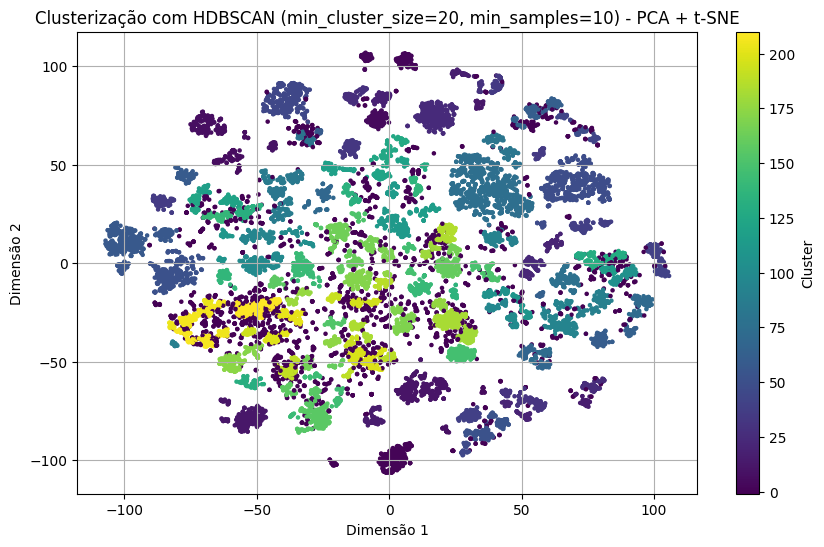

In [58]:
clusterizar_e_plotar_hdbscan(df_portarias_mgi, vColuna, min_cluster_size=20, min_samples=10, sufixo_coluna="hdbscan", sufixo_grafico="PCA + t-SNE")

#### 2.2.5) Redução com UMAP

In [59]:
vColuna = 'SBERT_Embeddings4_UMAP'
resultado_hdbscan = processar_hdbscan_e_clusterizar(df_portarias_mgi, vColuna, min_cluster_sizes = [20, 30, 40, 50], min_samples_values = [2, 5, 10, 15])

# Exibir os resultados
resultado_hdbscan.head(100)

Iniciando o processamento para várias combinações de min_cluster_size e min_samples...
Processando HDBSCAN para min_cluster_size=20, min_samples=2...
Processando HDBSCAN para min_cluster_size=20, min_samples=5...
Processando HDBSCAN para min_cluster_size=20, min_samples=10...
Processando HDBSCAN para min_cluster_size=20, min_samples=15...
Processando HDBSCAN para min_cluster_size=30, min_samples=2...
Processando HDBSCAN para min_cluster_size=30, min_samples=5...
Processando HDBSCAN para min_cluster_size=30, min_samples=10...
Processando HDBSCAN para min_cluster_size=30, min_samples=15...
Processando HDBSCAN para min_cluster_size=40, min_samples=2...
Processando HDBSCAN para min_cluster_size=40, min_samples=5...
Processando HDBSCAN para min_cluster_size=40, min_samples=10...
Processando HDBSCAN para min_cluster_size=40, min_samples=15...
Processando HDBSCAN para min_cluster_size=50, min_samples=2...
Processando HDBSCAN para min_cluster_size=50, min_samples=5...
Processando HDBSCAN para 

min_cluster_size  min_samples  Silhouette Score  Davies-Bouldin Score  \
0                 20            2          0.643293              0.434976   
1                 20            5          0.686152              0.391830   
2                 20           10          0.702119              0.363824   
3                 20           15          0.705930              0.329245   
4                 30            2          0.664035              0.426608   
5                 30            5          0.685711              0.404080   
6                 30           10          0.689121              0.396716   
7                 30           15          0.697569              0.364685   
8                 40            2          0.655117              0.450215   
9                 40            5          0.673672              0.441206   
10                40           10          0.667420              0.411054   
11                40           15          0.682464              0.401732   
12                50            2          0.638659              0.448962   
13                50            5          0.659429              0.439455   
14                50           10          0.672256              0.412499   
15                50           15          0.680746              0.393294   

    Calinski-Harabasz Score  ruido_percent  clusters_validos  
0             236220.312500          11.58               282  
1             263764.406250          13.31               266  
2             195166.156250          13.69               248  
3             173264.656250          14.44               225  
4             192983.062500          12.15               213  
5             158939.765625          13.00               200  
6             150504.625000          13.67               189  
7             153528.828125          15.17               177  
8             154969.484375          12.10               169  
9             128492.593750          13.10               162  
10             97443.062500          11.72               138  
11            140551.343750          15.51               142  
12             96256.289062          11.92               129  
13             92088.945312          12.11               123  
14            102067.609375          12.50               115  
15            105174.085938          14.99               115


--- Métricas de Avaliação ---
Índice de Silhueta (clusters válidos): 0.667420
Índice de Davies-Bouldin (clusters válidos): 0.411054
Índice de Calinski-Harabasz (clusters válidos): 97443.06
Proporção de ruído: 11.72%
Total de clusters válidos (excluindo ruído): 139
Gerando gráfico dos clusters...


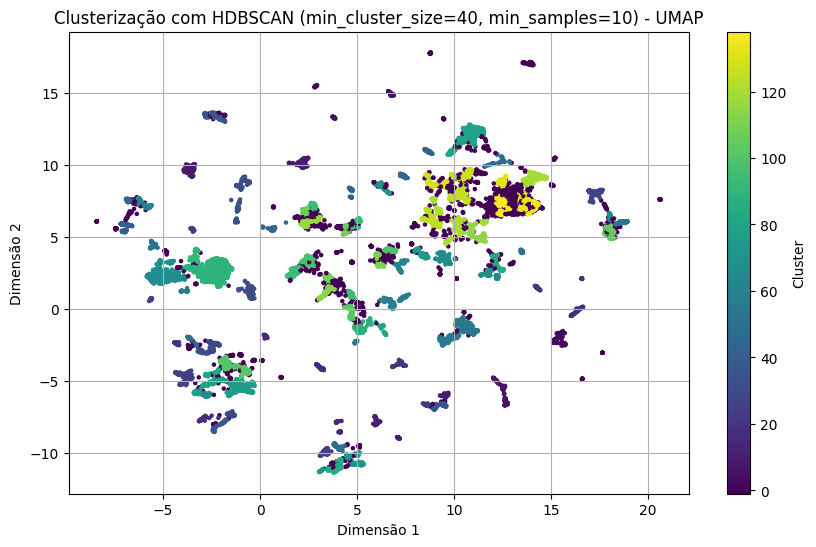

In [60]:
clusterizar_e_plotar_hdbscan(97443.06, vColuna, min_cluster_size=40, min_samples=10, sufixo_coluna="hdbscan", sufixo_grafico="UMAP")

In [63]:
# Salva saída parcial o arquivo completo com novas colunas
df_portarias_mgi.to_parquet(f'./saida/06_3_DOU{secao}_portarias_mgi_tratado_NER_lematizado_embeddingsUSE_SBERT_Reducao_Kmeans_DBSCAN_HDBSCAN.parquet', engine='pyarrow', index=False)